This notebook is used to characterize strong inhibitors and weak inhibitors:
- Molecular Weight
- Number of Hydrogen bond acceptor
- Number of hydrogen bond domor
- Number of rotatable bonds
- LOGP

In [1]:
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bioassay_file = './cleaned_inactivated_cdk2_bioactivities_minset.txt'
IC50 = []
COMPNAMES = []
SMILES = {}
with open(bioassay_file, 'r') as file:
    for line in file.readlines():
        info = line.strip().split(',')
        COMPNAMES.append(info[0])
        IC50.append((info[0], float(info[-1])))
        SMILES[info[0]] = info[1]
print(f'Number of compounds: {len(COMPNAMES)}')
IC50 = dict(IC50)

Number of compounds: 164


## Remove compounds in CDK2 cocrystal structures

In [3]:
import rdkit
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.Draw as Draw
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

In [4]:
pid_file = 'CDK2_1h00_90identity.txt'
cdk2_identity = []
with open(pid_file, 'r') as file:
    for line in file.readlines():
        tmp = [item.strip().lower() for item in line.split(',')]
        cdk2_identity.extend(tmp)
print('Number of 90% sequence identity structures in PDB:', len(cdk2_identity))

Number of 90% sequence identity structures in PDB: 438


In [5]:
## load PDBBind general set
general_df = pd.read_excel('../data/PDBBind_general_set_20230524_052154.xlsx', header=1) # 'Canonical SMILES'
mask = general_df['PDB code'].apply(lambda x: x in cdk2_identity)
cocrystal_smis = general_df[mask]['Canonical SMILES'].tolist()
print('Number of ligands in cocrystal structures:', len(cocrystal_smis))
lst = []
cocrystal_ligs = []
cocrystal_fps = []
for smi in cocrystal_smis:
    try:
        mol = Chem.MolFromSmiles(smi)
        fp = FingerprintMols.FingerprintMol(mol)
        lst.append(smi)
        cocrystal_ligs.append(mol)
        cocrystal_fps.append(fp)
    except:
        print(smi)
cocrystal_smis = lst
print('Number of valid ligands:', len(cocrystal_smis))

Number of ligands in cocrystal structures: 255
N#[C]=CN(c1ccc(cc1Br)C)c1ncnc(c1)Nc1ccc(cc1)OC[C@H](C[NH+](C)C)O
Number of valid ligands: 254


[15:34:11] Explicit valence for atom # 1 C, 5, is greater than permitted


In [6]:
similarity = 0.95
SIMILAR_COMPNAMES = []
for name in SMILES:
    smi = SMILES[name]
    fp = FingerprintMols.FingerprintMol(Chem.MolFromSmiles(smi))
    sims = np.array([DataStructs.FingerprintSimilarity(fp, ref_fp) for ref_fp in cocrystal_fps])
    if np.sum(sims >= similarity) >=1:
        SIMILAR_COMPNAMES.append(name)
print('Number of similar compounds in the screening compound library:', len(SIMILAR_COMPNAMES))
print(SIMILAR_COMPNAMES)

Number of similar compounds in the screening compound library: 17
['CHEMBL101558', 'CHEMBL474441', 'CHEMBL460102', 'CHEMBL319467', 'CHEMBL2163612', 'CHEMBL460103', 'CHEMBL101557', 'CHEMBL102926', 'CHEMBL178179', 'CHEMBL462192', 'CHEMBL206109', 'CHEMBL257831', 'CHEMBL484571', 'CHEMBL455657', 'CHEMBL485618', 'CHEMBL4741442', 'CHEMBL1234086']


In [7]:
COMPNAMES = set(COMPNAMES) - set(SIMILAR_COMPNAMES)
COMPNAMES = list(COMPNAMES)
print(f'Number of remaining compounds: {len(COMPNAMES)}')

Number of remaining compounds: 147


## Strong Inhibitors vs. Weak Inhibitors

In [8]:
strong_mols = []
weak_mols = []

for name in COMPNAMES:
    smi = SMILES.get(name, None)
    v = IC50.get(name, None)
    if (smi is None) or (v is None):
        continue
    
    mol = Chem.MolFromSmiles(smi)
    if v <= 10:
        strong_mols.append(mol)
    elif v >= 10_000:
        weak_mols.append(mol)
print('Number of strong inhibitors:', len(strong_mols))
print('Number of weak inhibitors:', len(weak_mols))

Number of strong inhibitors: 97
Number of weak inhibitors: 50


## LogP

In [9]:
plt.rcParams['font.size'] = 24
plt.rcParams['lines.linewidth'] = 2

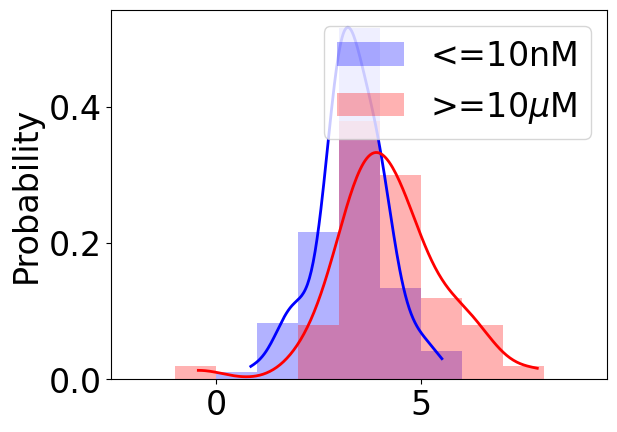

In [20]:
act_logP = [Descriptors.MolLogP(mol) for mol in strong_mols]
inact_logP = [Descriptors.MolLogP(mol) for mol in weak_mols]
fig, ax = plt.subplots()
bins = list(range(-2, 10))
sns.histplot(act_logP, ax=ax, bins=bins, kde=True, stat='probability', \
             color='blue', edgecolor='none', alpha=0.3, label=r'<=$10$nM')
sns.histplot(inact_logP, ax=ax, bins=bins, kde=True, stat='probability', \
             color='red', edgecolor='none', alpha=0.3, label=r'>=$10\mu$M')
plt.legend()

## Molecular Weight

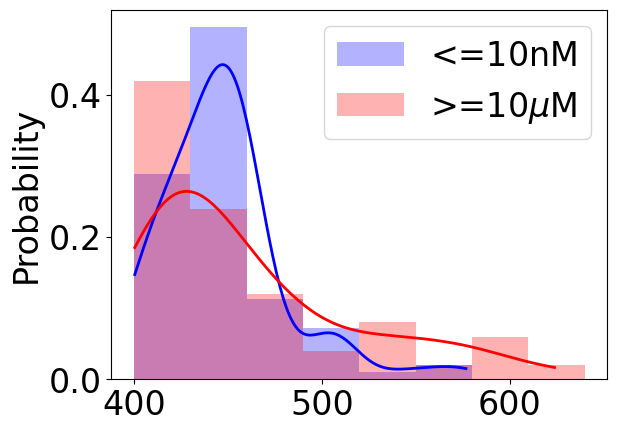

In [27]:
act_mw = [Descriptors.MolWt(mol) for mol in strong_mols]
inact_mw = [Descriptors.MolWt(mol) for mol in weak_mols]
fig, ax = plt.subplots()
bins = list(range(400, 650, 30))
sns.histplot(act_mw, ax=ax, bins=bins, kde=True, stat='probability', \
             color='blue', edgecolor='none', alpha=0.3, label=r'<=$10$nM')
sns.histplot(inact_mw, ax=ax, bins=bins, kde=True, stat='probability', \
             color='red', edgecolor='none', alpha=0.3, label=r'>=$10\mu$M')
plt.legend()

## Donor

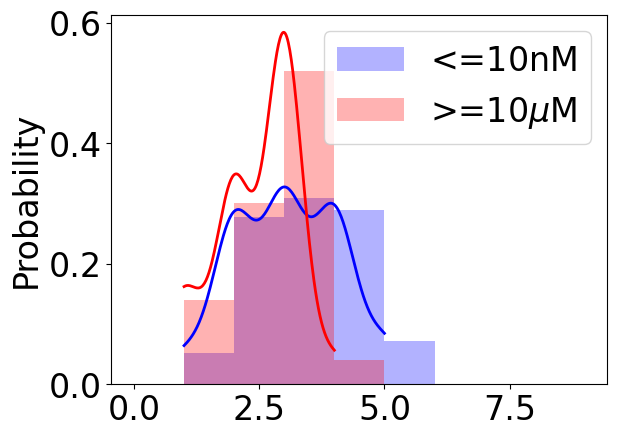

In [21]:
act_donor = [Chem.Lipinski.NumHDonors(mol) for mol in strong_mols]
inact_donor = [Chem.Lipinski.NumHDonors(mol) for mol in weak_mols]
fig, ax = plt.subplots()
bins = list(range(10))
sns.histplot(act_donor, ax=ax, bins=bins, kde=True, stat='probability', \
             color='blue', edgecolor='none', alpha=0.3, label=r'<=$10$nM')
sns.histplot(inact_donor, ax=ax, bins=bins, kde=True, stat='probability', \
             color='red', edgecolor='none', alpha=0.3, label=r'>=$10\mu$M')
plt.legend()

## Acceptors

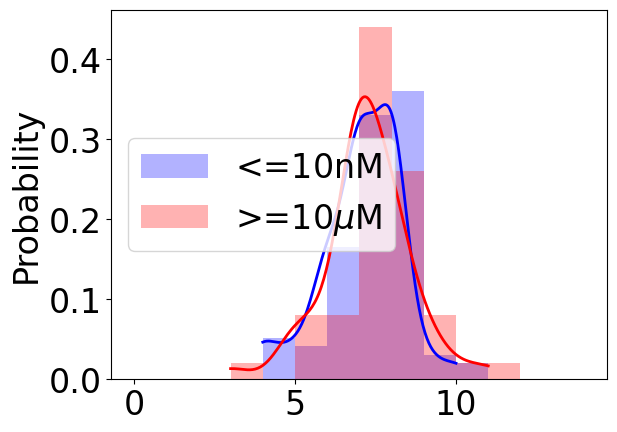

In [23]:
act_acc = [Chem.Lipinski.NumHAcceptors(mol) for mol in strong_mols]
inact_acc = [Chem.Lipinski.NumHAcceptors(mol) for mol in weak_mols]
fig, ax = plt.subplots()
bins = list(range(15))
sns.histplot(act_acc, ax=ax, bins=bins, kde=True, stat='probability', \
             color='blue', edgecolor='none', alpha=0.3, label=r'<=$10$nM')
sns.histplot(inact_acc, ax=ax, bins=bins, kde=True, stat='probability', \
             color='red', edgecolor='none', alpha=0.3, label=r'>=$10\mu$M')
plt.legend()

## Rotatable Bonds

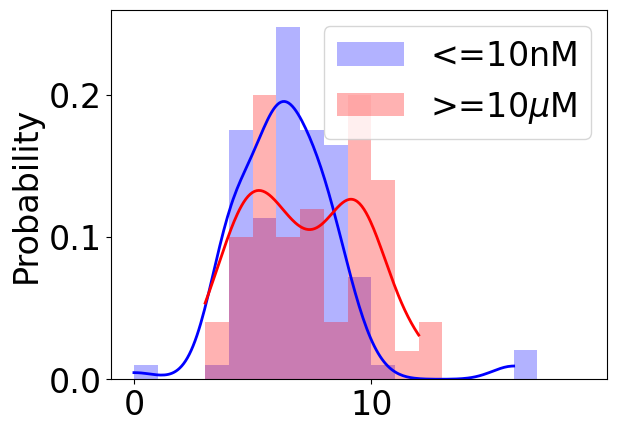

In [24]:
act_bonds = [Descriptors.NumRotatableBonds(mol) for mol in strong_mols]
inact_bonds = [Descriptors.NumRotatableBonds(mol) for mol in weak_mols]
fig, ax = plt.subplots()
bins = list(range(20))
sns.histplot(act_bonds, ax=ax, bins=bins, kde=True, stat='probability', \
             color='blue', edgecolor='none', alpha=0.3, label=r'<=$10$nM')
sns.histplot(inact_bonds, ax=ax, bins=bins, kde=True, stat='probability', \
             color='red', edgecolor='none', alpha=0.3, label=r'>=$10\mu$M')
plt.legend()